In [1]:
# -*- coding: utf-8 -*-
"""
   Introduction to Deep Learning (LDA-T3114)
   Skeleton code for Assignment 4: Regularization and Optimization Techniques on MNIST

   Hande Celikkanat & Miikka Silfverberg
"""

'\n   Introduction to Deep Learning (LDA-T3114)\n   Skeleton code for Assignment 4: Regularization and Optimization Techniques on MNIST\n\n   Hande Celikkanat & Miikka Silfverberg\n'

In [3]:
%matplotlib inline

In [90]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from random import shuffle

from plotting import *

torch.set_num_threads(20)

1

In [91]:
#--- hyperparameters ---
N_EPOCHS = 5
BATCH_SIZE=30
N_FEATURES = 28*28
N_CLASSES = 10
TEST_EVERY = 1
STATUS_EVERY = 1

# You are encouraged to play with these default parameter values for every option!
OPTIONS = dict()

# Regularization options:
OPTIONS['NO_REG'] = {'OPTIM':'Adam', 'LR':0.0001, 'L2_WEIGHT':0,   'MOMENT':0,   'DROP_P':0}
OPTIONS['DROP']   = {'OPTIM':'Adam', 'LR':0.0001, 'L2_WEIGHT':0,   'MOMENT':0,   'DROP_P':0.5} 
                                                                            # Note that in Pytorch the dropout 
                                                                            # parameter p is the "drop" probability, 
                                                                            # rather than the "include" probability.
OPTIONS['L2']     = {'OPTIM':'Adam', 'LR':0.0001, 'L2_WEIGHT':0.2, 'MOMENT':0,   'DROP_P':0}

# Optimization options:
OPTIONS['NO_OPT'] = {'OPTIM':'SGD', 'LR':0.0001, 'L2_WEIGHT':0,   'MOMENT':0,   'DROP_P':0} 
OPTIONS['MOMENT'] = {'OPTIM':'SGD', 'LR':0.0001, 'L2_WEIGHT':0,   'MOMENT':0.9, 'DROP_P':0} 
OPTIONS['ADAM']   = {'OPTIM':'Adam', 'LR':0.0001, 'L2_WEIGHT':0,   'MOMENT':0,   'DROP_P':0}


In [92]:
# --- MNIST initialization ---

# torchvision.datasets.MNIST outputs a set of PIL images
# We transform them to tensors
transform2tensor = torchvision.transforms.ToTensor()

#Load the data to data folder and transform to tensors.
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform2tensor)
mnist_testset  = datasets.MNIST(root='../data', train=False, download=True, transform=transform2tensor)

print('Train set size: %d' % (len(mnist_trainset)))
print('Test set size: %d' % (len(mnist_testset)))

# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)

Train set size: 60000
Test set size: 10000


In [93]:
#--- model ---
# YOU CAN PREP 6 DIFFERENT LogisticReg CLASS DEFINITIONS IF YOU LIKE, OR ELSE USE THIS ONE DEFINITION FOR ALL OF THE 6 MODELS 
class LogisticReg(nn.Module):
    def __init__(self, 
                 n_features, 
                 n_classes,
                 drop,
                 extra_arg_2 = None):
        super(LogisticReg, self).__init__()
        
        # WRITE CODE HERE
        self.linear =  nn.Linear(n_features,n_classes)
        # INIT DROPOUT LAYER HERE
        self.p = drop["DROP_P"]
        self.dropout =  nn.Dropout(p=drop["DROP_P"])
        
    
   
        
    def forward(self, x):
        # WRITE CODE HERE
        output = self.linear(x)
        # USE DROPOUT LAYER HERE
        output = self.dropout(output)
        return F.log_softmax(output,dim=1)
    

In [94]:
# --- evaluation function ---
def evaluate(dataset_loader,model):
    correct = 0
    total = 0

    model.eval()
    
    for i, (eval_images, eval_labels) in enumerate(dataset_loader):
        eval_images = eval_images.view(-1, N_FEATURES)

        # WRITE CODE HERE
        output = model(eval_images)
        _, predicted = torch.max(output.data, 1) 
        
        
        total += eval_labels.size(0) #count amount of labels
        correct += torch.eq(predicted,eval_labels).sum().item() #how many matches
        
    return 100.0 * correct / total

In [95]:
#--- set up ---

# WRITE CODE HERE

# Below is a dummy initialization. You need to rewrite this part with corresponding initializations for 
# every option.
# Please use the values in the OPTIONS dictionary to initialize your model and optimizer.
# If you like, you can change the values in the OPTIONS dictionary above.
# An example initialization for NO_REG option:
# models['NO_REG'] = LogisticReg(n_features, n_classes, drop = OPTIONS['NO_REG'])
# optimizers['NO_REG'] = optim.SGD(models['NO_OPT'].parameters(), 
#                                  lr=OPTIONS['NO_OPT']['LR'], 
#                                  momentum=OPTIONS['NO_OPT']['MOMENT'],
#                                  weight_decay=OPTIONS['NO_OPT']['L2_WEIGHT'])
# All the options should be initialized similarly.
models = {option:LogisticReg(n_features=N_FEATURES, n_classes = N_CLASSES, drop = OPTIONS[option]) for option in ['NO_REG', 'DROP', 'L2', 'NO_OPT', 'MOMENT', 'ADAM']}





optimizers = {option:optim.Adam(models[option].parameters(),
                               lr=OPTIONS[option]["LR"],
                               weight_decay=OPTIONS[option]["L2_WEIGHT"])
              for option in ['NO_REG', 'DROP', 'L2', 'ADAM']}


for option in ["NO_OPT","MOMENT"]:
    optimizers[option] = optim.SGD(models[option].parameters(),
                               lr=OPTIONS[option]["LR"],
                               momentum=OPTIONS[option]["MOMENT"],
                               weight_decay=OPTIONS[option]["L2_WEIGHT"])


loss_function = nn.NLLLoss() 


train_accs = dict()
test_accs  = dict()
epochs     = dict()

In [96]:
#--- training loop ---
for option in ['NO_REG', 'DROP', 'L2', 'NO_OPT', 'MOMENT', 'ADAM']:
    print('Training option %s' % (option))
    
    optimizer = optimizers[option]
    model = models[option]
    
    train_accs[option] = []
    test_accs[option]  = []
    epochs[option]     = []
    
    
    
    for epoch in range(N_EPOCHS):
        model.train()       
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.view(BATCH_SIZE, N_FEATURES) #30,784
            
            # WRITE CODE HERE
            optimizer.zero_grad()
            output = model(images)
            loss = loss_function(output,labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss+=loss
            
        if ((epoch+1) % TEST_EVERY) == 0:
            train_acc = evaluate(train_loader,model)
            test_acc = evaluate(test_loader,model)
            
            #save results to dicts
            train_accs[option].append(train_acc)
            test_accs[option].append(test_acc)
            epochs[option].append(epoch)
            
            print('epoch: %d, loss: %.2f, train acc: %.2f%%, test acc: %.2f%%' % 
                  (epoch+1, total_loss, train_acc, test_acc))

        elif ((epoch+1) % STATUS_EVERY) == 0:
            print('epoch: %d, loss: %.2f' % (epoch+1, total_loss))

Training option NO_REG
epoch: 1, loss: 2209.70, train acc: 86.05%, test acc: 86.63%
epoch: 2, loss: 1076.85, train acc: 88.43%, test acc: 89.08%
epoch: 3, loss: 858.33, train acc: 89.52%, test acc: 90.20%
epoch: 4, loss: 764.11, train acc: 90.30%, test acc: 90.81%
epoch: 5, loss: 711.68, train acc: 90.65%, test acc: 91.09%
Training option DROP
epoch: 1, loss: 3119.12, train acc: 86.86%, test acc: 87.50%
epoch: 2, loss: 2518.11, train acc: 88.78%, test acc: 89.44%
epoch: 3, loss: 2402.27, train acc: 89.57%, test acc: 90.13%
epoch: 4, loss: 2360.46, train acc: 89.98%, test acc: 90.47%
epoch: 5, loss: 2330.76, train acc: 90.32%, test acc: 90.85%
Training option L2
epoch: 1, loss: 2599.60, train acc: 83.42%, test acc: 84.47%
epoch: 2, loss: 1985.60, train acc: 84.10%, test acc: 84.96%
epoch: 3, loss: 1959.55, train acc: 84.11%, test acc: 85.13%
epoch: 4, loss: 1956.34, train acc: 84.69%, test acc: 85.65%
epoch: 5, loss: 1954.94, train acc: 84.12%, test acc: 85.10%
Training option NO_OPT
ep

### About the training process
- Here I just used 5 epochs to reduce training time. 
- In order to get more reliable results epochs should be raised. 
- However an increase in accuracy in most cases is 5-7%. The most remarkable change can be seen in case of "NO_OPT" -> change from 43% to 75%. With more epochs accuracies would get higher.

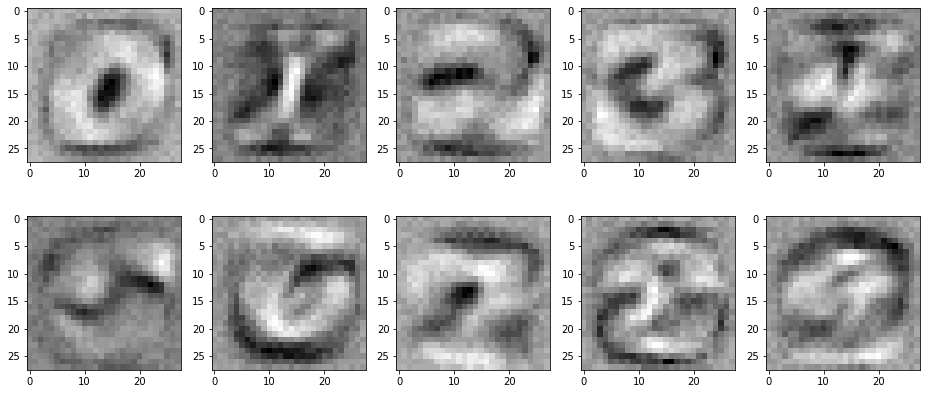

In [107]:
#--- comparisons ---
# This plotting is interesting for only the optimization options:
Weights = models['NO_REG'].linear.weight.detach().numpy()
plot_mnist_weights(Weights, 'NO_REG')

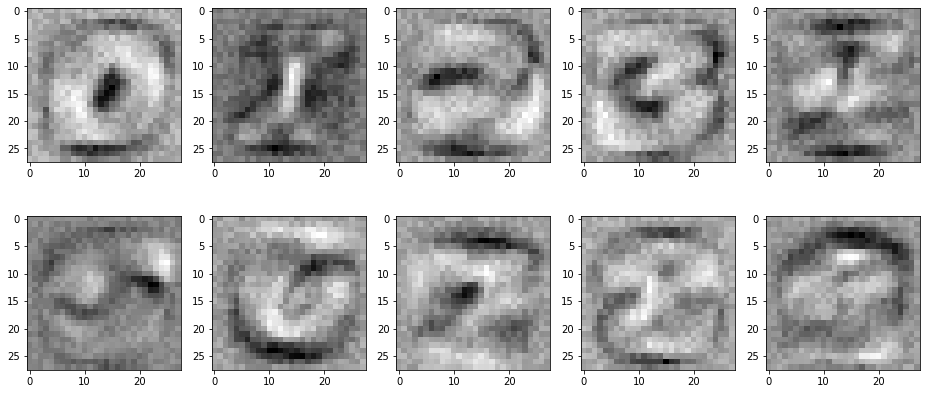

In [108]:
Weights = models['DROP'].linear.weight.detach().numpy()
plot_mnist_weights(Weights, 'DROP') 

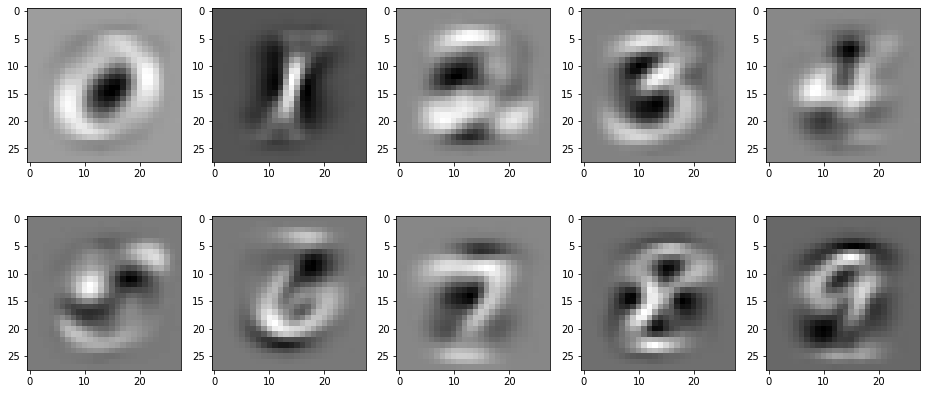

In [109]:
Weights = models['L2'].linear.weight.detach().numpy()
plot_mnist_weights(Weights, 'L2')

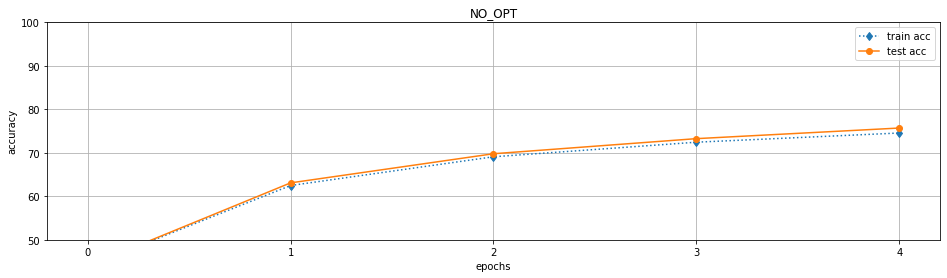

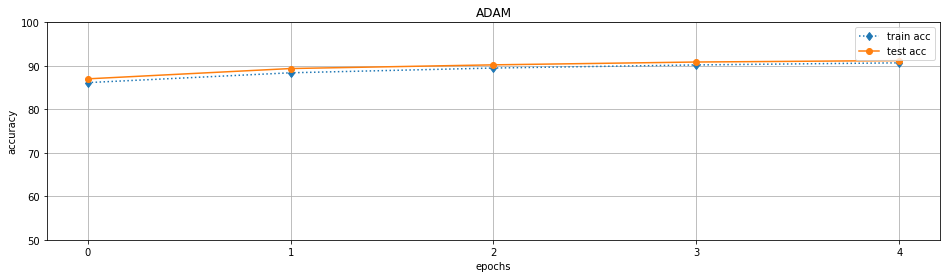

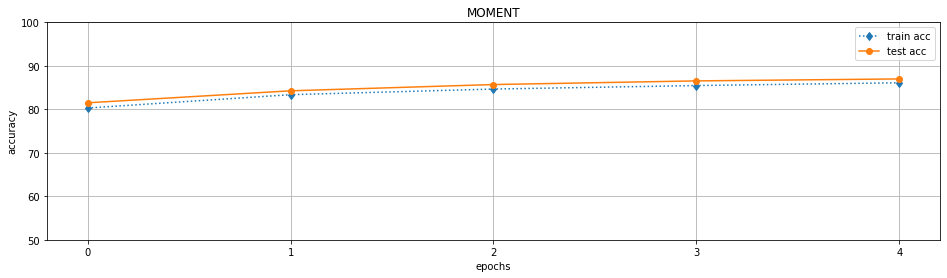

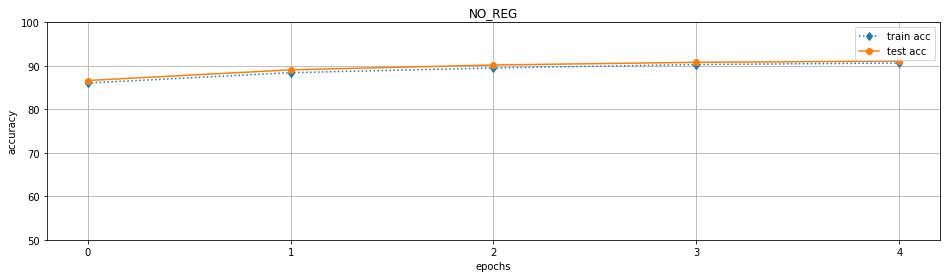

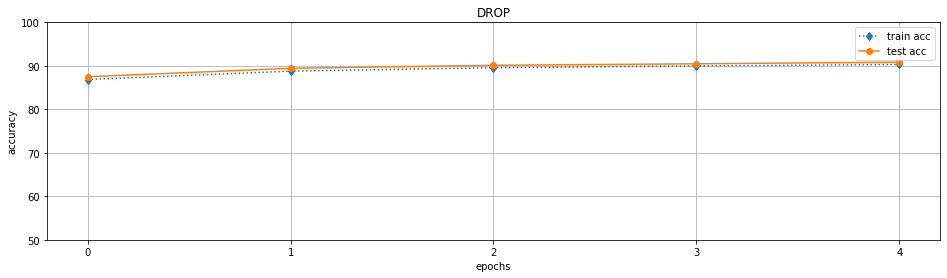

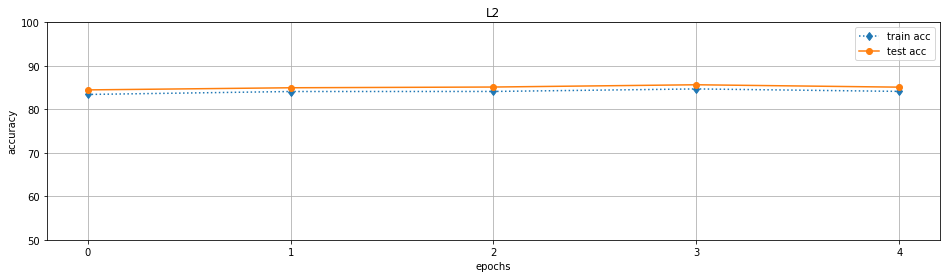

In [110]:
# We want to see the accuracies for both the optimization options and the regularization
# options:
plot_accs(train_accs, test_accs, epochs)